In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import sklearn.metrics as metrics

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

import sqldf
import warnings
import statsmodels.api as sm
from sklearn.metrics import classification_report

# Predicting COVID-19 Death's Across The Country
BIOSTAT 823 Final Project

By Dapo Adegbile & Jasmine Young

## Introduction

COVID-19 has been changing the world as we know it for the past year 18+ months. In this project we will be using data from the CDC to predict the likelihood of death based on a patient's characteristics. We will use features like race, age, whether the person was symptomatic, or whether they were hospitalized to predict their health outcome. We will use both Logistic Regression and a Random Forest Model to tackle this classification problem. We will use this notebook to walk you through our data cleaning process, our data analysis, model building, and evaluation. 

## Data Cleaning With SQL & Pandas

We ran into issues with our dataset being too large originally. We first attempted to look at only one state (North Carolina), but our models weren't performing well. Eventually, we decided to keep all fifty states and eliminate all null, missing, and unknown values to reduce the file size. We also split the file into two parts so that we could store it on Github.

#### Our Data Cleaning Consists Of:
- Loading the file and removing null values on Colab: https://colab.research.google.com/drive/1_2QLGQcWQ-N5_BIH_ZwLUwVVi2RibBRT?usp=sharing
- Using SQL to remove MISSING values for the following columns: sex, race, ethnicity, age, symptom status, death, and hospitalization
- Using SQL to remove UNKNOWN values for the following columns: sex, race, ethnicity, age, symptom status, death, and hospitalization
- Create numerical month variable (0-20) to replace case month
- Code death as zero or one instead of Yes/No
- Create dummy variables for age, sex, ethnicity, symptom status, underlying conditions, hospitalized, and race.

In [2]:
# Load in data 
warnings.simplefilter(action='ignore', category=FutureWarning)
covidp1 = pd.read_csv('covid_part1.csv',index_col=0)
covidp2 = pd.read_csv('covid_part2.csv',index_col=0)
covidv2 = pd.concat([covidp1, covidp2])

In [3]:
#Remove values labeled as MISSING
query = """
SELECT *
FROM covidv2
WHERE (sex != 'Missing') AND (race != 'Missing') AND (ethnicity != 'Missing') AND 
(age_group != 'Missing') AND (symptom_status != 'Missing') AND (death_yn != 'Missing') AND
(hosp_yn != 'Missing');
"""
covidv2 = sqldf.run(query)

In [4]:
#Remove values labeled as UNKNOWN
query1 = """
SELECT *
FROM covidv2
WHERE (sex != 'Unknown') AND (race != 'Unknown') AND (ethnicity != 'Unknown') AND 
(age_group != 'Unknown') AND (symptom_status != 'Unknown') AND (death_yn != 'Unknown') AND
(hosp_yn != 'Unknown');
"""
covidv2 = sqldf.run(query1)

In [5]:
#Create case month variable for regression
covidv2['Adj_Case_Month'] = pd.to_datetime(covidv2['case_month'])
min_date = covidv2['Adj_Case_Month'].min()
covidv2['Adj_Case_Month'] = covidv2['Adj_Case_Month'].apply(lambda x: (x.year - min_date.year) * 12 + (x.month - min_date.month))

#Code Death as 0 or 1
covidv2 = covidv2.replace({'death_yn': {'Yes': 1,'No': 0}})

In [6]:
#Create dummy variables
covidv2 = pd.get_dummies(covidv2, columns=["age_group"])
covidv2 = pd.get_dummies(covidv2, columns=["sex"])
covidv2 = pd.get_dummies(covidv2, columns=["ethnicity"])
covidv2 = pd.get_dummies(covidv2, columns=["symptom_status"])
covidv2 = pd.get_dummies(covidv2, columns=["underlying_conditions_yn"])
covidv2 = pd.get_dummies(covidv2, columns=["hosp_yn"])
covidv2 = pd.get_dummies(covidv2, columns=["race"])

In [7]:
covidv2.head()

,level_0,index,case_month,res_state,icu_yn,death_yn,Adj_Case_Month,age_group_0 - 17 years,age_group_18 to 49 years,age_group_50 to 64 years,...,underlying_conditions_yn_No,underlying_conditions_yn_Yes,hosp_yn_No,hosp_yn_Yes,race_American Indian/Alaska Native,race_Asian,race_Black,race_Multiple/Other,race_Native Hawaiian/Other Pacific Islander,race_White
0,0,346,2021-04,OH,No,0,14,0,1,0,...,1,0,1,0,0,0,0,0,0,1
1,1,747,2020-05,TN,No,0,3,0,0,1,...,0,1,1,0,0,0,0,0,0,1
2,2,819,2020-04,NJ,No,0,2,0,1,0,...,0,1,0,1,0,0,1,0,0,0
3,3,1216,2020-08,KS,No,0,6,0,1,0,...,0,1,1,0,0,0,0,0,0,1
4,4,1341,2020-07,KS,No,0,5,0,1,0,...,1,0,1,0,0,0,0,0,0,1


## Exploratory Data Analysis

We conducted most of our exploratory data analysis using pandas profiling. I've included a couple of plots of interest below. We see that our dataset is distributed across months with a skew. We can see that we have the most cases concentrated in the winter months of 2020 and the early months of 2021. We have the least cases for January and February of 2020. We also see that our dataset is not equally balanced between all states. Many of our records come from Ohio, North Carolina, and Arkansas. These states may be the most represented because they took the most detailed records and had fewer unknown/missing entries.

In [8]:
from pandas_profiling import ProfileReport
ProfileReport(covidv2)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Text(0, 0.5, 'Frequency')

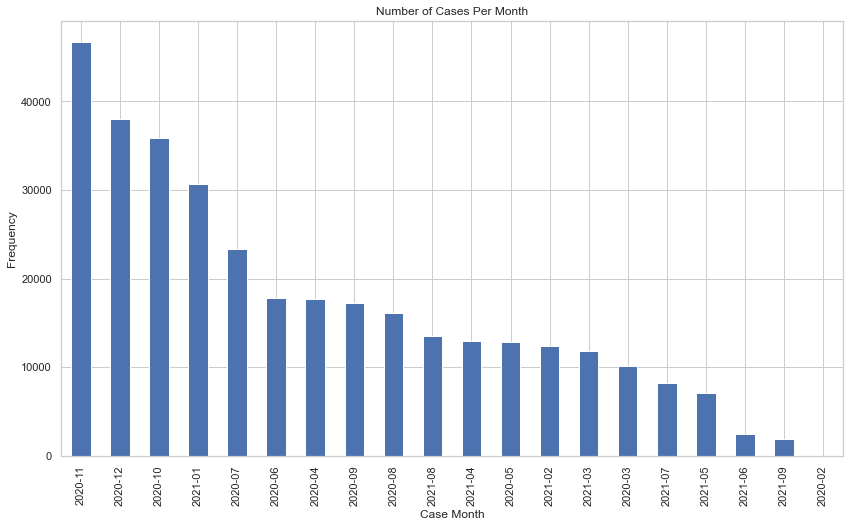

In [25]:
ax = covidv2['case_month'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Number of Cases Per Month")
ax.set_xlabel("Case Month")
ax.set_ylabel("Frequency")

Text(0, 0.5, 'Frequency')

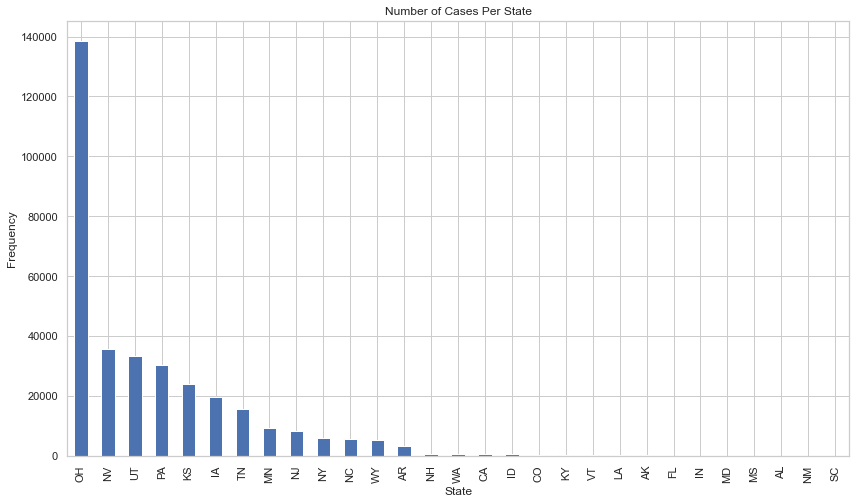

In [26]:
ax = covidv2['res_state'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Number of Cases Per State")
ax.set_xlabel("State")
ax.set_ylabel("Frequency")

## Covid Dashboard - Streamlit

We created a dashboard in streamlit to gain more understanding of our data. The Dashboard contains trends of covid deaths, hospitalizations, and ICU admittances by month and the percentage of deaths by race. 

We also added an interactive bar chart that plots covid deaths based on the months and state as defined by user input. A link to the dashboard can be found [here](https://share.streamlit.io/dapoade/biostat823-final-project/main/CovidDashboard.py).


## Logistic Regression

#### Before Running Logistic Regression:
- Split our data into a 75/25 train/test split.
- Define our dependent variables as: race (excluding White), case month, age (excluding 0-17), sex (excluding Male), ethnicity (excluding Non-Hispanic), sympton status (excluding non-symptomatic), underlying conditions (excluding No), hospitalized (excluding No).
- Define our independent variable as death or chance of dying.

We initially ran into problems determining which variables should be included in the regression, and which variable made the most sense as our response variable. The regression was not successful with missing or unknown values, though they were not coded as 'NaN'. We also had to exclude one of each group, for example excluding White but keeping our other racial groups. Excluding groups allowed the regression to run successfuly and the coefficients to be interpreted. 

In [11]:
X_train, X_test, y_train, y_test = train_test_split(covidv2.drop(['death_yn'],axis=1), covidv2[['death_yn']], test_size=0.25, random_state=123)

In [12]:
# defining the dependent and independent variables
X_train = X_train[['race_American Indian/Alaska Native', 'race_Asian', 'race_Black',
       'race_Multiple/Other', 'race_Native Hawaiian/Other Pacific Islander','Adj_Case_Month',
        'age_group_18 to 49 years','age_group_50 to 64 years', 'age_group_65+ years', 'sex_Female',
        'ethnicity_Hispanic/Latino','symptom_status_Symptomatic','underlying_conditions_yn_Yes', 'hosp_yn_Yes']]
X_train = sm.add_constant(X_train)
  
# building the model and fitting the data
log_reg = sm.Logit(y_train, X_train.astype(float)).fit()

         Current function value: 0.110813
         Iterations: 35


/Users/jasmineyoung/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


In [13]:
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:               death_yn   No. Observations:               252715
Model:                          Logit   Df Residuals:                   252700
Method:                           MLE   Df Model:                           14
Date:                Sun, 21 Nov 2021   Pseudo R-squ.:                  0.4239
Time:                        16:06:17   Log-Likelihood:                -28004.
converged:                      False   LL-Null:                       -48614.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                         -32.4188   2.72e+04     -0.001      0.999   -5.34e+04    5.33e+04
race_American Indian/Alaska Nati

In [14]:
np.exp(log_reg.params)

const                                          8.331097e-15
race_American Indian/Alaska Native             3.087910e-07
race_Asian                                     2.048578e+00
race_Black                                     1.288480e+00
race_Multiple/Other                            3.397808e-01
race_Native Hawaiian/Other Pacific Islander    5.992882e-07
Adj_Case_Month                                 8.818769e-01
age_group_18 to 49 years                       6.013173e+09
age_group_50 to 64 years                       4.537157e+10
age_group_65+ years                            3.655780e+11
sex_Female                                     6.803647e-01
ethnicity_Hispanic/Latino                      1.711670e+00
symptom_status_Symptomatic                     7.875870e-01
underlying_conditions_yn_Yes                   5.540816e+01
hosp_yn_Yes                                    1.068544e+01
dtype: float64

#### Interpreting our regression coefficients
Our significant variables, at a 95% threshold, are Race (Asian, Black, Multiple/Other), Case Month, Sex (Female), Ethnicity (Hispanic/Latino), Symptom status, underlying conditions, and hospitalization. We use the exponentiated version of our coefficients above to determine results.

The intercept tells us that the chance of death for a white male patient, from 0-17 years old, in the first month of the pandemic, that is not ethnically hispanic/latino, without symptoms, without underlying conditions, and without hospitalization is very very small (less than 0.000001 %).The chance of death is **increased by 105% for Asian patients**, compared to white patients holding all else constant. The chance of death is **increased by 29% for Black patients**, compared to white patients holding all else constant. The chance of death is **decreased by 66% for Multiple/Other race patients**, compared to white patients holding all else constant. The chance of death is **decreased by 12% for each additional month into the pandemic** that the case occurs holding all else constant. The chance of death is **decreased by 32% for female patients** when compared to male patients holding all else constant. The chance of death is **increased by 71% for patients of Hispanic/Latino ethnicity**, when compared to patients who are not holding all else constant. The chance of death is **decreased by 21% for those that are symptomatic** compared to those who are not holding all else constant. The chance of death **increases by 5441% for patients who have underlying conditions**, when compared to those who do not holding all else constant. The chance of death **increases by 970% for those who are hospitalized**, compared to those who are not holding all else constant.

#### Logistic Regression Performance Results
Our logistic regression has a test accuracy of 0.9541. Our confusion matrix below shows that we have more false negatives than false positives. The area under our ROC curve is 0.59.

In [15]:
from sklearn.metrics import (confusion_matrix,
                           accuracy_score)

# Perform predictions
X_test = X_test[['race_American Indian/Alaska Native', 'race_Asian', 'race_Black',
       'race_Multiple/Other', 'race_Native Hawaiian/Other Pacific Islander','Adj_Case_Month',
        'age_group_18 to 49 years','age_group_50 to 64 years', 'age_group_65+ years', 'sex_Female',
        'ethnicity_Hispanic/Latino','symptom_status_Symptomatic','underlying_conditions_yn_Yes', 'hosp_yn_Yes']]
X_test = sm.add_constant(X_test)
yhat = log_reg.predict(X_test)
prediction = list(map(round, yhat))

cm = confusion_matrix(y_test, prediction)
print ("Confusion Matrix : \n", cm)
 
print('Test accuracy = ', accuracy_score(y_test, prediction))

Confusion Matrix : 
 [[79594   572]
 [ 3295   778]]
Test accuracy =  0.9540948966630658


Text(0.5, 257.44, 'Predicted label')

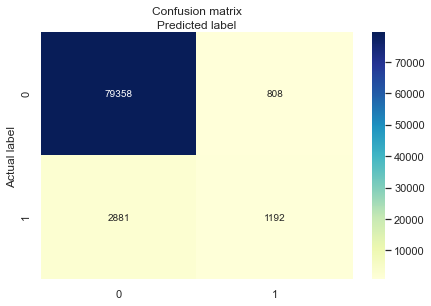

In [27]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

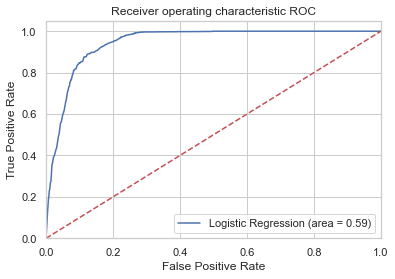

In [28]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, prediction)
fpr, tpr, thresholds = roc_curve(y_test, yhat)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ROC')
plt.legend(loc="lower right")

plt.show()

## Random Forest Model

Using the same clean data we create a second model, a random forest classifier with 100 estimators.

In [29]:
from sklearn.ensemble import RandomForestClassifier

rforest = RandomForestClassifier(n_estimators=100)
rforest.fit(X_train, y_train['death_yn'])

RandomForestClassifier()

#### Random Forest Performance Results
Our random forest model has a test accuracy of 0.9561. Our confusion matrix shows that we have more false negatives than false positives. The area under our ROC curve is 0.64.

In [30]:
y_pred_rf = rforest.predict(X_test)

In [31]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test,y_pred_rf))

Accuracy: 0.9561485772623132
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     80166
           1       0.59      0.30      0.39      4073

    accuracy                           0.96     84239
   macro avg       0.78      0.64      0.69     84239
weighted avg       0.95      0.96      0.95     84239



Confusion Matrix : 
 [[79340   826]
 [ 2868  1205]]


Text(0.5, 257.44, 'Predicted label')

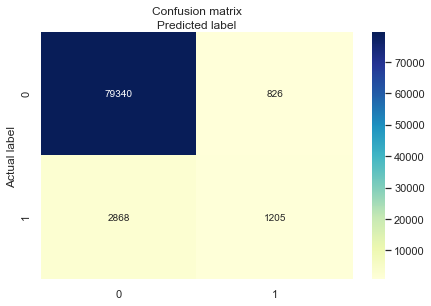

In [32]:
cm = confusion_matrix(y_test, y_pred_rf)
print ("Confusion Matrix : \n", cm)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

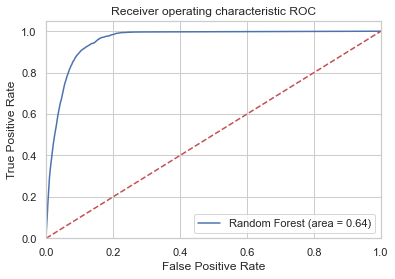

In [33]:
rf_roc_auc = roc_auc_score(y_test, rforest.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rforest.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ROC')
plt.legend(loc="lower right")

plt.show()

#### Visualizaing Important Features

For our random forest model we are able to visualize the importance of our features. For the data we provided, hospitalization, the case month, and being 65+ were the features with the most importance. Underlying conditions, being Native Hawaiian/Pacific Islander, and being American Indian/Alaska native were the least important features.

In [23]:
feature_imp = pd.Series(rforest.feature_importances_,index=X_train.columns).sort_values(ascending=False)

No handles with labels found to put in legend.


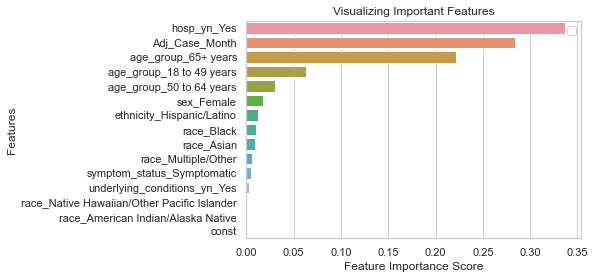

In [24]:
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

## Results

In conclusion, both of our models performed well with over 95% accuracy. Our random forest model performed slightly better with a test accuracy of .9561, compared to our Logistic Regression with a test accuracy of .9541. Our Random Forest model had a slightly larger area under it's ROC curve as well (0.64), compared to our Logistic Regression (0.59.) We consider our Random Forest model slightly more successful for these two reasons.

Our models also gave us some insight into what features were most important when considering life outcomes for COVID-19 patients. Our Logistic Regression pointed to underlying conditions, hospitalization, and some racial categories as the most important contributors to the chance of death. Our Random Forest model pointed to hospitalization, the month of the case, and being 65+ as the most important contributors. Overall, we've been able to reinforce some of the biggest risk factors for severe COVID-19 cases. Our models were able to successfully highlight trends in patient data and predict life outcomes with reasonable accuracy.

## Individual Contributions

We worked together to identify our data source and scope out the direction of our project.

#### Jasmine Young

I worked on including SQL applications in our data cleaning, refining, and modifying the logistic regression and random forest models within this notebook. I also worked on most of the text/analysis within the notebook.

In this project I learned that working with very large datasets can be challenging. Cleaning and manipulating big datasets is incredibly important for meaningful analysis. I also learned that medical data can have lots of missing and unlabeled values, that make creating prediction models incredibly difficult. Lastly, I learned that many of the risk factors for COVID are supported by the CDC data - age, symptoms, and underlying conditions are associated with worse outcomes for patients. 

#### Dapo Adegbile

I was responsible for some of the data cleaning / variable transformations and the first iterations of our logistic regression and random forest classifier. I also created and deployed the dashboard in streamlit.

Through this project I learned the importance of creatively cleaning your data and the importance of good data enginereing. I also was able to learn more about making interactive dashboards in streamlit. Additionally, like Jasmine stated, I was made aware of the complications that come with working with medical data making predicting on said data difficult. 